# Setup

In [1]:
import magnet as mag
import magnet.nodes as mn
import magnet.nodes.functional as mF
import magnet.debug as mdb

from magnet.data import Data
from magnet.utils.images import show_images
from magnet.training import SupervisedTrainer
from magnet.training import callbacks
from magnet.utils import summarize

Running your code on a boring CPU.


In [2]:
import torch

from torch import nn, optim
from torch.nn import functional as F

from torchvision import transforms

In [3]:
jtplot_style()

In [4]:
@mag.eval
def order(model, data, c=10, n=5):
    x, y = next(iter(data(mode='val')))
    channels, rows, cols = x.shape[1:]
    images = torch.zeros(n, c, channels, rows, cols)

    images_gathered = [0] * c
    correct = 0
    dl = iter(data(shuffle=True, mode='val'))
    for i in range(len(dl)):
        x, y_true = next(dl)
        y = model(x)[0].max(0)[1].item()
        
        n_y = images_gathered[y]
        if n_y >= n: continue
            
        if y == y_true.item(): correct += 1
        else: x *= -1
        images[n_y, y] = x[0]
        images_gathered[y] += 1
    
    show_images(images.view(-1, channels, rows, cols), cmap='gray',
                pixel_range=(-1, 1), titles=f'{int(correct * 100 / (c * n))}%')

In [38]:
def visualize_weights(model, s=28):
    show_images(model.layer.weight.view(10, -1, s, s),
                cmap='seismic', pixel_range='auto')

In [6]:
DIR_CHECKPOINTS = DIR_MAIN / 'checkpoints'
DIR_CHECKPOINTS.mkdir(parents=True, exist_ok=True)

# Main

In [7]:
data = Data.get('mnist')
x, y = next(data(batch_size=64))

In [48]:
model = mn.Linear(10, act=None)
with mag.eval(model): model(x).shape

summarize(model, x)

+--------+-----------+----------------------+
|  Node  |   Shape   | Trainable Parameters |
+--------+-----------+----------------------+
| input  | 1, 28, 28 |          0           |
+--------+-----------+----------------------+
| Linear |    10     |        7,850         |
+--------+-----------+----------------------+
Total Trainable Parameters: 7,850


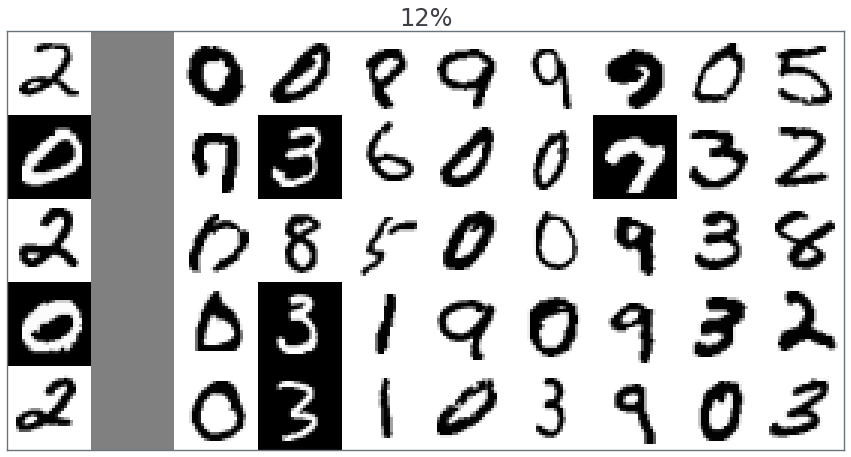

In [9]:
order(model, data)

In [49]:
trainer = SupervisedTrainer(model, metrics='accuracy')

In [50]:
trainer.train(data(batch_size=64, shuffle=True, sample_space=0.1),
              callbacks=[
                        callbacks.Validate(data(batch_size=64, mode='val'),
                                            SupervisedTrainer.validate),
                        callbacks.Monitor(),
                        ])

/home/vaisakh/.magnet/magnet/utils/statistical.py:122: RuntimeWarning: window_fraction (0.3) too low for order (3) and length (10) of data
Returning raw data
  RuntimeWarning)


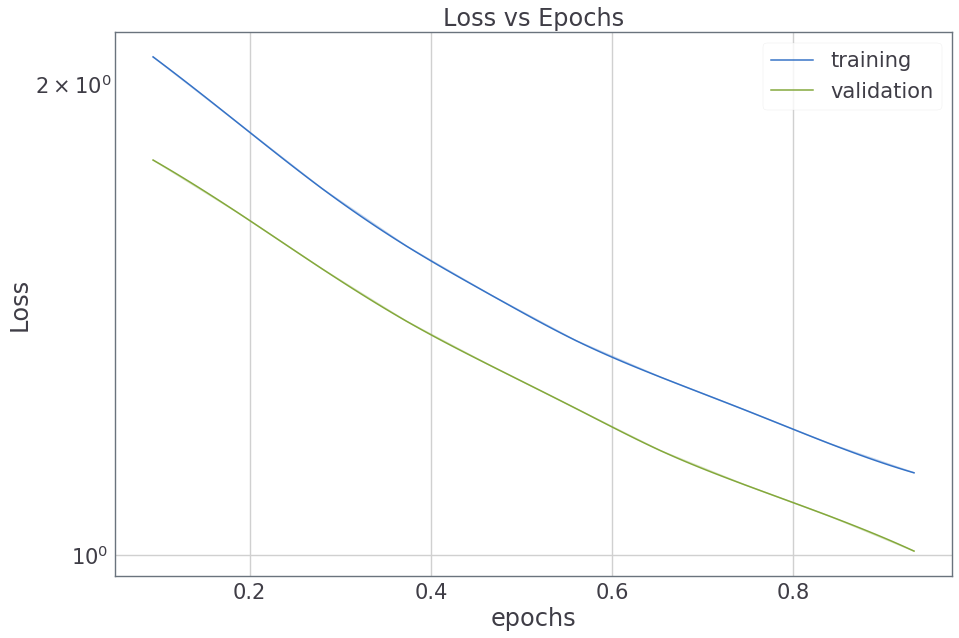

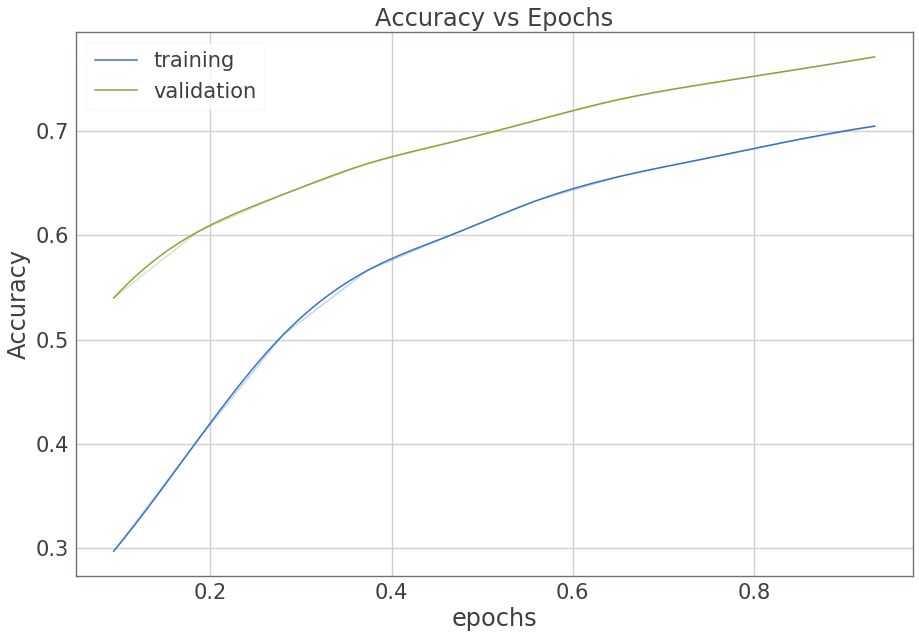

In [51]:
trainer.callbacks[1]

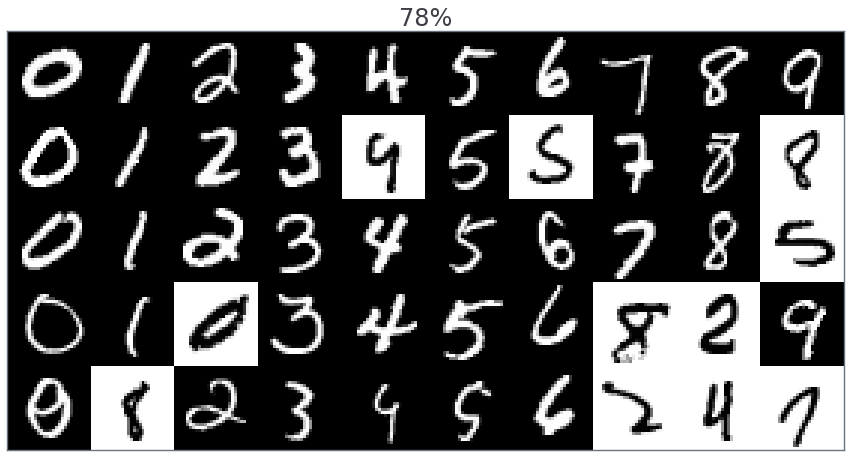

In [52]:
model.eval()
order(model, data)

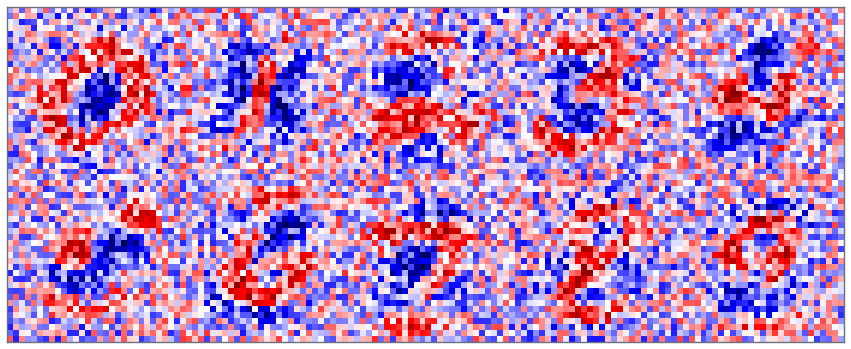

In [53]:
visualize_weights(model)